In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eye-diseases-classification/dataset/glaucoma/1255_right.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/1482_left.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_398_8823411.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_309_4110303.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_13_697490.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_205_310538.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/Glaucoma_040.png
/kaggle/input/eye-diseases-classification/dataset/glaucoma/1256_right.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_221_3079640.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_392_9636183.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_12_5295071.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_399_7128170.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_113_8738972.jpg
/kaggle/input/eye-disea

In [27]:
import os
import time
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split



In [55]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=1280, num_heads=4, ff_dim=256, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-Attention
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))

        # Feedforward
        ff_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

class EffTransNet(nn.Module):
    def __init__(self, num_classes=5, transformer_depth=2):
        super(EffTransNet, self).__init__()

        # Load pretrained EfficientNetB0
        backbone = models.efficientnet_b0(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])  # Exclude classifier

        self.embed_dim = 1280
        self.transformer_layers = nn.Sequential(
            *[TransformerEncoderBlock(embed_dim=self.embed_dim) for _ in range(transformer_depth)]
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(self.embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.backbone(x)              # [B, 1280, 7, 7]
        x = x.view(batch_size, self.embed_dim, -1).permute(0, 2, 1)  # [B, 49, 1280]
        x = self.transformer_layers(x)    # [B, 49, 1280]
        x = self.pool(x.permute(0, 2, 1)).squeeze(-1)  # [B, 1280]
        x = self.classifier(x)            # [B, num_classes]
        return x

# Instantiate model
model = EffTransNet(num_classes=5).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Optional: Model Summary
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EffTransNet(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activatio

In [56]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('/kaggle/working/split-dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/working/split-dataset/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [57]:
import time
import torch

train_losses, val_losses, val_accuracies, train_accuracies = [], [], [], []
best_val_acc = 0.0

# Track total training time
total_train_time = 0

for epoch in range(10):
    start_time = time.time()  # Start time for epoch
    
    # Training phase
    model.train()
    total_loss, correct = 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    epoch_time = time.time() - start_time
    total_train_time += epoch_time

    # GPU Memory usage (optional)
    if torch.cuda.is_available():
        mem_allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GB
        mem_reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)    # in GB
        print(f"Epoch {epoch+1} GPU memory: Allocated: {mem_allocated:.3f} GB, Reserved: {mem_reserved:.3f} GB")

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc*100:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.2f}%, "
          f"Time: {epoch_time:.2f} seconds")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_efftransnet_model11.pth')
        print(f"Best model saved at epoch {epoch+1}")

print(f"Total training time: {total_train_time:.2f} seconds")


Epoch 1 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]


Epoch 1 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 1: Train Loss=0.4927, Train Acc=80.92%, Val Loss=0.2142, Val Acc=92.07%, Time: 24.86 seconds
Best model saved at epoch 1


Epoch 2 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.58it/s]


Epoch 2 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 2: Train Loss=0.2065, Train Acc=92.46%, Val Loss=0.2136, Val Acc=93.23%, Time: 24.85 seconds
Best model saved at epoch 2


Epoch 3 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.59it/s]


Epoch 3 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 3: Train Loss=0.1408, Train Acc=94.85%, Val Loss=0.2451, Val Acc=92.92%, Time: 25.41 seconds


Epoch 4 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


Epoch 4 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 4: Train Loss=0.1050, Train Acc=96.52%, Val Loss=0.1756, Val Acc=94.61%, Time: 25.38 seconds
Best model saved at epoch 4


Epoch 5 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s]


Epoch 5 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 5: Train Loss=0.0663, Train Acc=97.47%, Val Loss=0.1937, Val Acc=94.93%, Time: 25.40 seconds
Best model saved at epoch 5


Epoch 6 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Epoch 6 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 6: Train Loss=0.0555, Train Acc=98.07%, Val Loss=0.2034, Val Acc=93.97%, Time: 25.93 seconds


Epoch 7 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.60it/s]


Epoch 7 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 7: Train Loss=0.0504, Train Acc=98.24%, Val Loss=0.1894, Val Acc=95.03%, Time: 24.77 seconds
Best model saved at epoch 7


Epoch 8 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


Epoch 8 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 8: Train Loss=0.0414, Train Acc=98.59%, Val Loss=0.1995, Val Acc=95.14%, Time: 25.70 seconds
Best model saved at epoch 8


Epoch 9 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.62it/s]


Epoch 9 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 9: Train Loss=0.0461, Train Acc=98.50%, Val Loss=0.2414, Val Acc=94.08%, Time: 25.75 seconds


Epoch 10 [Val]: 100%|██████████| 30/30 [00:05<00:00,  5.59it/s]

Epoch 10 GPU memory: Allocated: 0.375 GB, Reserved: 3.541 GB
Epoch 10: Train Loss=0.0324, Train Acc=98.88%, Val Loss=0.2298, Val Acc=95.14%, Time: 24.60 seconds
Total training time: 252.64 seconds


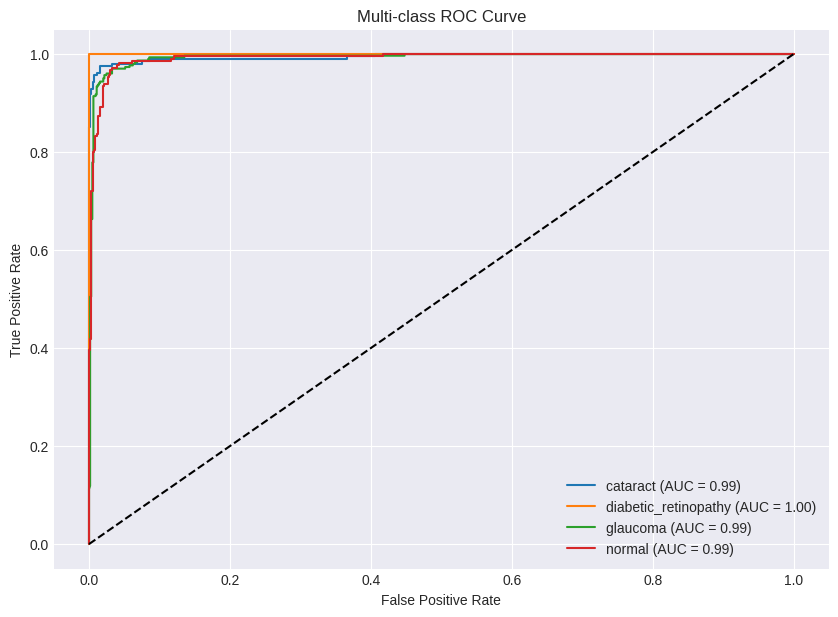

In [58]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have:
# y_true: list of true labels (int)
# y_scores: list of predicted probabilities per class (list of lists or numpy array)
num_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_scores_np = np.array(y_scores)

plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


/tmp/ipykernel_35/886163233.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # nicer style


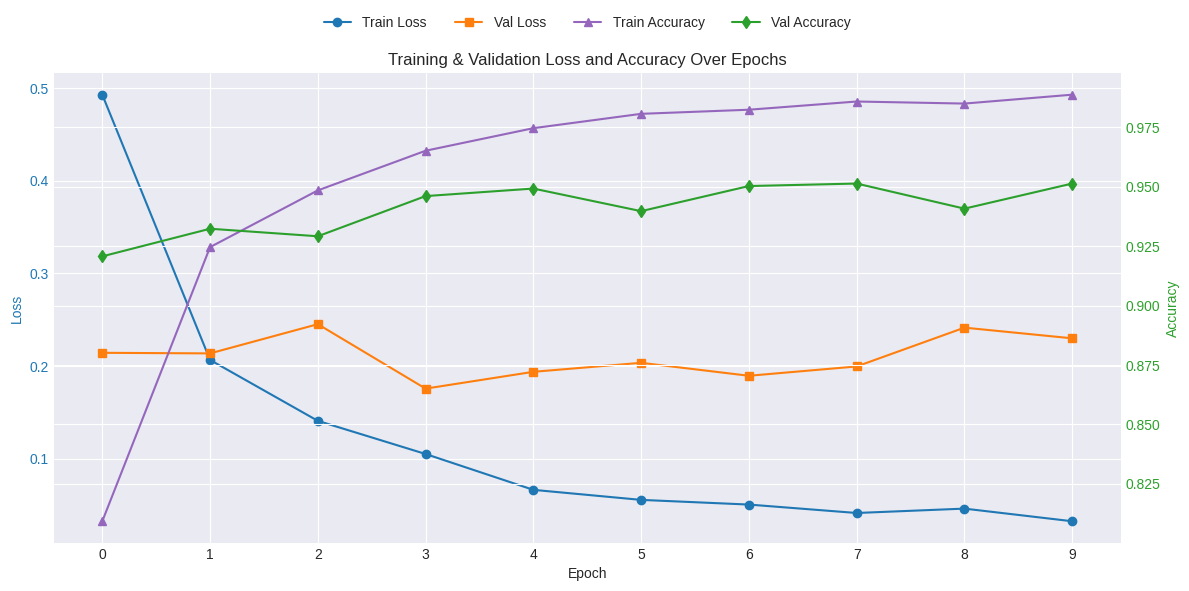

In [59]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')  # nicer style

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot losses on left y-axis
ax1.plot(train_losses, 'o-', color='tab:blue', label='Train Loss')
ax1.plot(val_losses, 's-', color='tab:orange', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(range(len(train_losses)))

# Create a twin y-axis to plot accuracies
ax2 = ax1.twinx()
ax2.plot(train_accuracies, '^-', color='tab:purple', label='Train Accuracy')
ax2.plot(val_accuracies, 'd-', color='tab:green', label='Val Accuracy')
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

plt.title("Training & Validation Loss and Accuracy Over Epochs")
plt.tight_layout()
plt.show()


/tmp/ipykernel_35/1424120057.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # clean style


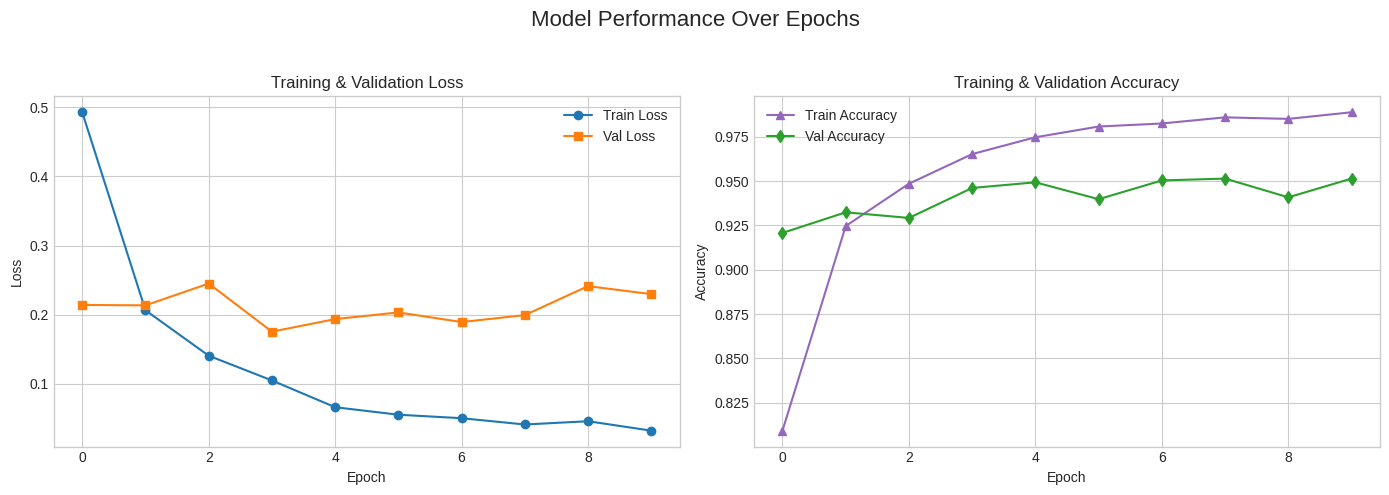

In [60]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')  # clean style

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Losses
ax1.plot(train_losses, 'o-', label='Train Loss', color='tab:blue')
ax1.plot(val_losses, 's-', label='Val Loss', color='tab:orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot Accuracies
ax2.plot(train_accuracies, '^-', label='Train Accuracy', color='tab:purple')
ax2.plot(val_accuracies, 'd-', label='Val Accuracy', color='tab:green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.suptitle("Model Performance Over Epochs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


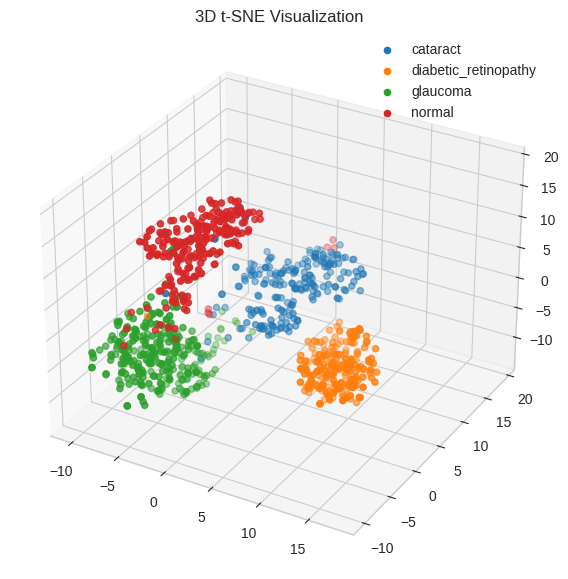

In [62]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

features, labels = [], []
with torch.no_grad():
    for images, label in val_loader:
        images = images.to(device)
        # Extract features from your model (customize as per your model's architecture)
        x = model.backbone(images)
        x = x.view(x.size(0), 1280, -1).permute(0, 2, 1)
        x = model.transformer_layers(x)
        x = model.pool(x.permute(0, 2, 1)).squeeze(-1)

        features.extend(x.cpu().numpy())
        labels.extend(label.numpy())

features = np.array(features)  # <--- convert list to numpy array
labels = np.array(labels)      # optional but useful for indexing

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(features)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, c in enumerate(class_names):
    indices = labels == i
    ax.scatter(X_tsne[indices, 0], X_tsne[indices, 1], X_tsne[indices, 2], label=c)

ax.legend()
ax.set_title("3D t-SNE Visualization")
plt.show()


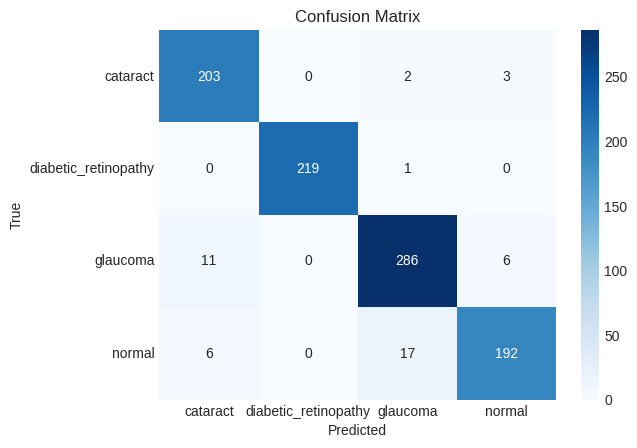

                      precision    recall  f1-score   support

            cataract       0.92      0.98      0.95       208
diabetic_retinopathy       1.00      1.00      1.00       220
            glaucoma       0.93      0.94      0.94       303
              normal       0.96      0.89      0.92       215

            accuracy                           0.95       946
           macro avg       0.95      0.95      0.95       946
        weighted avg       0.95      0.95      0.95       946



In [63]:
model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))
